# 노래 추천시스템 구현

In [2]:
# 필요한 모듈과 라이브러리를 로딩합니다.
import sys
import os 
import pandas as pd
import numpy as np   
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import urllib.request
import requests
import re
from PIL import Image
from io import BytesIO
from bs4 import BeautifulSoup    
from selenium import webdriver   
import time
import csv
from tqdm.notebook import tqdm 
from selenium.webdriver.common.by import By
from konlpy.tag import *
from sklearn.metrics.pairwise import cosine_similarity
from nltk import Text
from wordcloud import WordCloud

# 한글 시각화
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

### 1. 멜론 데이터 크롤링

In [3]:
'''
# 크롬드라이버 열기
driver = webdriver.Chrome('chromedriver') # 크롬드라이버 경로
driver.maximize_window() # 크롬창 크기 최대

# 작성할 'testdata.csv' 파일을 생성하여 변수 'f'에 저장
f = open('test.csv', 'w', newline = '')

# CSV 파일을 작성하는 객체 변수 'wtr' 생성
wtr = csv.writer(f)

# 열 제목 작성
wtr.writerow(['제목', '가수', '앨범 커버', '가사'])

# 멜론 차트 (발라드 스테디셀러)
melon_chart = "https://www.melon.com/genre/song_list.htm?gnrCode=GN0100&steadyYn=Y#params%5BgnrCode%5D=GN0100&params%5BdtlGnrCode%5D=&params%5BorderBy%5D=NEW&params%5BsteadyYn%5D=Y&po=pageObj&startIndex=1"
driver.get(melon_chart)
time.sleep(1)

# 1위 - 50위
for i in range(50):
    # 제목
    xpath1 = "/html/body/div/div[3]/div/div/div[5]/form/div/table/tbody/tr[" + str(i+1) + "]/td[5]/div/div/div[1]/span/a"
    title = driver.find_element(By.XPATH, xpath1).text

    # 가수
    xpath2 = "/html/body/div/div[3]/div/div/div[5]/form/div/table/tbody/tr[" + str(i+1) + "]/td[5]/div/div/div[2]/a"
    singer = driver.find_element(By.XPATH, xpath2).text
    singer = singer.replace('\xc9', 'E') # 로제 (ROSÉ) -> 로제 (ROSE)

    # 앨범 커버
    xpath3 = "/html/body/div/div[3]/div/div/div[5]/form/div/table/tbody/tr[" + str(i+1) + "]/td[3]/div/a/img"
    album_cover = driver.find_element(By.XPATH, xpath3).get_attribute('src')

    # 버튼
    xpath4 = "/html/body/div/div[3]/div/div/div[5]/form/div/table/tbody/tr[" + str(i+1) + "]/td[4]/div/a"
    button = driver.find_element(By.XPATH, xpath4)
    button.click()
    time.sleep(1)

    # 가사
    xpath5 = "/html/body/div[1]/div[3]/div/div/div/div[2]/div[2]/div"
    lyrics = driver.find_element(By.XPATH, xpath5).text

    # csv 파일 기록
    wtr.writerow([i+1, title, singer, album_cover, lyrics])

    # 뒤로 가기
    driver.back()
    time.sleep(1)

driver.close()
f.close()
'''

'\n# 크롬드라이버 열기\ndriver = webdriver.Chrome(\'chromedriver\') # 크롬드라이버 경로\ndriver.maximize_window() # 크롬창 크기 최대\n\n# 작성할 \'testdata.csv\' 파일을 생성하여 변수 \'f\'에 저장\nf = open(\'test.csv\', \'w\', newline = \'\')\n\n# CSV 파일을 작성하는 객체 변수 \'wtr\' 생성\nwtr = csv.writer(f)\n\n# 열 제목 작성\nwtr.writerow([\'제목\', \'가수\', \'앨범 커버\', \'가사\'])\n\n# 멜론 차트 (발라드 스테디셀러)\nmelon_chart = "https://www.melon.com/genre/song_list.htm?gnrCode=GN0100&steadyYn=Y#params%5BgnrCode%5D=GN0100&params%5BdtlGnrCode%5D=&params%5BorderBy%5D=NEW&params%5BsteadyYn%5D=Y&po=pageObj&startIndex=1"\ndriver.get(melon_chart)\ntime.sleep(1)\n\n# 1위 - 50위\nfor i in range(50):\n    # 제목\n    xpath1 = "/html/body/div/div[3]/div/div/div[5]/form/div/table/tbody/tr[" + str(i+1) + "]/td[5]/div/div/div[1]/span/a"\n    title = driver.find_element(By.XPATH, xpath1).text\n\n    # 가수\n    xpath2 = "/html/body/div/div[3]/div/div/div[5]/form/div/table/tbody/tr[" + str(i+1) + "]/td[5]/div/div/div[2]/a"\n    singer = driver.find_element(By.XPATH, xpath2)

### 2. 데이터 확인

In [3]:
# 데이터프레임 불러오기
df = pd.read_csv("test.csv", encoding='cp949')

In [4]:
df

,제목,가수,앨범 커버,가사
1,바람이 불었으면 좋겠어,길구봉구,https://cdnimg.melon.co.kr/cm/album/images/022...,웃는 모습이 너무 아름다운\n그런 너를 기억하면서\n괜찮아 넌 잘할거라 말하던\n또...
2,내 손을 잡아,아이유,https://cdnimg.melon.co.kr/cm/album/images/012...,느낌이 오잖아\n\n떨리고 있잖아\n\n언제까지 눈치만 볼 거니\n\n네 맘을 말해...
3,이 소설의 끝을 다시 써보려 해,한동근,https://cdnimg.melon.co.kr/cm/album/images/022...,시계가 반대로 돌아가고 있어\nTV속 영화가 되감아지고 있어\n내렸던 빗물이 올라가...
4,봄 사랑 벚꽃 말고,HIGH4 (하이포),https://cdnimg.melon.co.kr/cm/album/images/022...,길었던 겨우내 줄곧 품이 좀 남는\n밤색 코트\n그 속에 나를 쏙 감추고 걸음을\n...
5,Timeless,SG 워너비,https://cdnimg.melon.co.kr/cm/album/images/003...,어쩜 살아가다 보면 한 번은 날 찾을지 몰라\n나 그 기대 하나로 오늘도 힘겹게 버...
6,금요일에 만나요 (Feat. 장이정 Of HISTORY),아이유,https://cdnimg.melon.co.kr/cm/album/images/022...,월요일엔 아마 바쁘지 않을까\n화요일도 성급해 보이지 안 그래\n수요일은 뭔가 어정...
7,너의 모든 순간 (Original),성시경,https://cdnimg.melon.co.kr/cm/album/images/022...,이윽고 내가 한눈에\n너를 알아봤을 때\n모든 건 분명 달라지고 있었어\n내 세상은...
8,너의 의미 (Feat. 김창완),아이유,https://cdnimg.melon.co.kr/cm/album/images/022...,너의 그 한 마디 말도 그 웃음도\n나에겐 커다란 의미\n너의 그 작은 눈빛도\n쓸...
9,우연히 봄,로꼬,https://cdnimg.melon.co.kr/cm/album/images/023...,우연히 내게 오나봐\n봄 향기가 보여\n너도 같이 오나봐\n저 멀리서 니 향기가\n...
10,걱정말아요 그대,이적,https://cdnimg.melon.co.kr/cm/album/images/026...,그대여 아무 걱정 하지 말아요\n우리 함께 노래 합시다\n그대 아픈 기억들 모두 그...


### 3. 데이터 전처리

In [5]:
# 띄어쓰기를 빈칸으로 대체
df['가사'] = df['가사'].str.replace('\n', ' ')

In [6]:
# 정규 표현식을 통한 한글 외 문자 제거
df['가사'] = df['가사'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [7]:
# 1위 ~ 5위곡 가사 출력
df['가사'][:5]

1    웃는 모습이 너무 아름다운 그런 너를 기억하면서 괜찮아 넌 잘할거라 말하던 또 그런...
2    느낌이 오잖아  떨리고 있잖아  언제까지 눈치만 볼 거니  네 맘을 말해봐  딴청 ...
3    시계가 반대로 돌아가고 있어 속 영화가 되감아지고 있어 내렸던 빗물이 올라가고 있어...
4    길었던 겨우내 줄곧 품이 좀 남는 밤색 코트 그 속에 나를 쏙 감추고 걸음을 재촉해...
5    어쩜 살아가다 보면 한 번은 날 찾을지 몰라 나 그 기대 하나로 오늘도 힘겹게 버틴...
Name: 가사, dtype: object

In [8]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업
okt = Okt()

tokenized_data = []
for sentence in tqdm(df['가사']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

In [9]:
# 토큰화 결과
tokenized_data

[['웃다',
  '모습',
  '너무',
  '아름답다',
  '그렇다',
  '너',
  '기억',
  '괜찮다',
  '넌',
  '말',
  '또',
  '그렇다',
  '너',
  '기억',
  '뭐',
  '그리다',
  '내',
  '눈',
  '깊이',
  '박히다',
  '너무',
  '선명하다',
  '젠',
  '보내다',
  '없다',
  '바람',
  '불다',
  '좋다',
  '널',
  '잊다',
  '널',
  '씻다',
  '내',
  '도록',
  '바람',
  '불다',
  '좋다',
  '남다',
  '마음',
  '까지도',
  '멀리',
  '멀리',
  '날아가다',
  '수',
  '있다',
  '어느새다',
  '너',
  '얼굴',
  '을',
  '떠올리다',
  '또',
  '그렇다',
  '나르다',
  '바라보다',
  '뭐',
  '그리다',
  '내',
  '눈',
  '깊이',
  '박히다',
  '너무',
  '선명하다',
  '젠',
  '보내다',
  '없다',
  '바람',
  '불다',
  '좋다',
  '널',
  '잊다',
  '널',
  '씻다',
  '내',
  '도록',
  '바람',
  '불다',
  '좋다',
  '남다',
  '마음',
  '까지도',
  '멀리',
  '멀리',
  '날아가다',
  '수',
  '있다',
  '엉',
  '켜',
  '버리다',
  '나',
  '마음',
  '다시금',
  '너',
  '로',
  '제',
  '자리다',
  '찾아가다',
  '워',
  '머릴',
  '흔들다',
  '보다',
  '억지로',
  '다른',
  '생각',
  '을',
  '해도',
  '나',
  '너',
  '만',
  '내',
  '얘길',
  '들다',
  '좋다',
  '닿다',
  '수',
  '있다',
  '널',
  '볼',
  '수',
  '있다',
  '내',
  '얘길',
  '들다',
  '좋다',
  '흔들다',
  '수',
  '있다

### 4. EDA & Wordcloud

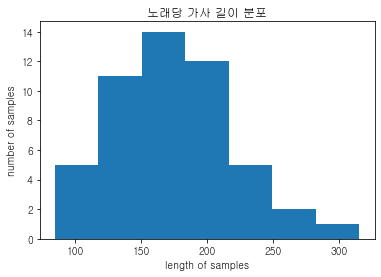

In [10]:
# 가사 길이 분포 확인 (토큰 개수)
plt.title("노래당 가사 길이 분포")
plt.hist([len(lyric) for lyric in tokenized_data], bins=7)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

<AxesSubplot:>

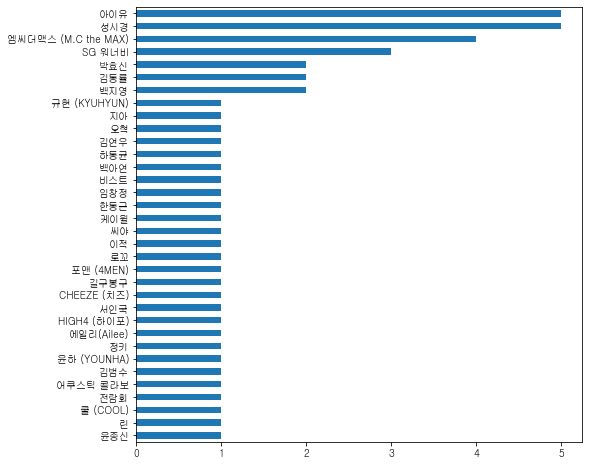

In [11]:
# 가수별 곡 수
plt.figure(figsize=(8,8))
df['가수'].value_counts().sort_values().plot(kind='barh')

In [12]:
# 성시경 노래 정보
ssk = df.loc[df['가수'] == '성시경']
ssk

,제목,가수,앨범 커버,가사
7,너의 모든 순간 (Original),성시경,https://cdnimg.melon.co.kr/cm/album/images/022...,이윽고 내가 한눈에 너를 알아봤을 때 모든 건 분명 달라지고 있었어 내 세상은 널 ...
11,거리에서,성시경,https://cdnimg.melon.co.kr/cm/album/images/003...,니가 없는 거리에는 내가 할일이 없어서 마냥 걷다 걷다보면 추억을 가끔 마주치...
18,크리스마스니까,성시경,https://cdnimg.melon.co.kr/cm/album/images/021...,오늘은 뭔가 좀 다른 기분 이젠 때가 된 것 같은 느낌 하늘에선 마침 눈이 내...
38,희재,성시경,https://cdnimg.melon.co.kr/cm/album/images/000...,햇살은 우릴 위해 내리고 바람도 서롤 감싸게 했죠 우리 웃음속에 계절은 오고 또 갔...
43,내게 오는 길,성시경,https://cdnimg.melon.co.kr/cm/album/images/000...,지금 곁에서 딴 생각에 잠겨 걷고 있는 그대 설레는 마음에 몰래 그대 모습 바라보면...


In [13]:
# 성시경의 각 노래별 명사 추출
okt = Okt()
ssk_token = []
for text in ssk['가사']:
    ssk_token += okt.nouns(text)

In [14]:
# 한 글자 명사 제외
for i,v in enumerate(ssk_token):
    if len(v) < 2:
        ssk_token.pop(i)

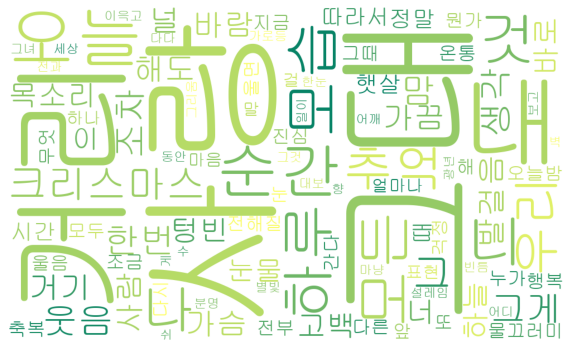

FreqDist({'사랑': 12, '그대': 12, '거리': 8, '내': 8, '오늘': 8, '순간': 7, '모든': 6, '니': 6, '것': 6, '모습': 6, ...})

In [15]:
ssk_ko = Text(ssk_token, name = "성시경 상위 5곡 가사 분석")

# 상위 단어 100개 선정
most_nouns = ssk_ko.vocab().most_common(100)

# 워드클라우드 설정
wc = WordCloud(width=1000, height=600,
               background_color="white", font_path=font_path, colormap='summer')

# 워드클라우드 생성 방법
wordcloud = wc.generate_from_frequencies(dict(most_nouns))

# 시각화
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
ssk_ko.vocab()

In [16]:
# 아이유 노래 정보
IU = df.loc[df['가수'] == '아이유']
IU

,제목,가수,앨범 커버,가사
2,내 손을 잡아,아이유,https://cdnimg.melon.co.kr/cm/album/images/012...,느낌이 오잖아 떨리고 있잖아 언제까지 눈치만 볼 거니 네 맘을 말해봐 딴청 ...
6,금요일에 만나요 (Feat. 장이정 Of HISTORY),아이유,https://cdnimg.melon.co.kr/cm/album/images/022...,월요일엔 아마 바쁘지 않을까 화요일도 성급해 보이지 안 그래 수요일은 뭔가 어정쩡한...
8,너의 의미 (Feat. 김창완),아이유,https://cdnimg.melon.co.kr/cm/album/images/022...,너의 그 한 마디 말도 그 웃음도 나에겐 커다란 의미 너의 그 작은 눈빛도 쓸쓸한 ...
27,무릎,아이유,https://cdnimg.melon.co.kr/cm/album/images/026...,모두 잠드는 밤에 혼자 우두커니 앉아 다 지나버린 오늘을 보내지 못하고서 깨어있어 ...
42,나의 옛날이야기,아이유,https://cdnimg.melon.co.kr/cm/album/images/022...,쓸쓸하던 그 골목을 당신은 기억하십니까 지금도 난 기억합니다 사랑한단 말 못하고 애...


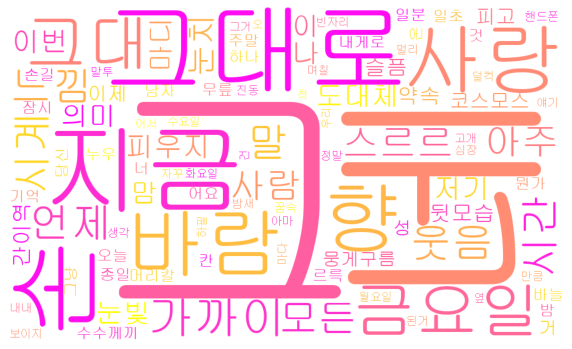

FreqDist({'그': 10, '네': 8, '그대로': 6, '지금': 6, '손': 6, '사랑': 6, '향': 6, '바람': 6, '금요일': 5, '그대': 5, ...})

In [17]:
# 아이유의 각 노래별 명사 추출
okt = Okt()
iu_token = []
for text in IU['가사']:
    iu_token += okt.nouns(text)

# 한 글자 명사 제외
for i,v in enumerate(iu_token):
    if len(v) == 1:
        iu_token.pop(i)

iu_ko = Text(iu_token, name = "아이유 상위 5곡 가사 분석")

# 상위 단어 100개 선정
most_nouns = iu_ko.vocab().most_common(100)

# 워드클라우드 설정
wc = WordCloud(width=1000, height=600,
               background_color="white", font_path=font_path, colormap='spring')

# 워드클라우드 생성 방법
wordcloud = wc.generate_from_frequencies(dict(most_nouns))

# 시각화
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
iu_ko.vocab()

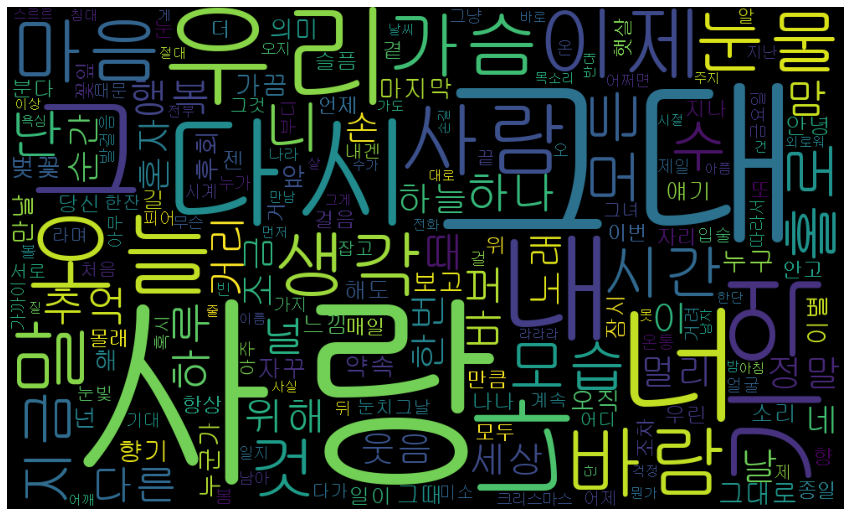

FreqDist({'사랑': 187, '그대': 134, '너': 59, '다시': 52, '내': 49, '그': 46, '우리': 44, '나': 41, '기억': 40, '오늘': 39, ...})

In [18]:
# 50곡의 각 노래별 명사 추출
okt = Okt()
token = []
for text in df['가사']:
    token += okt.nouns(text)

# 한 글자 명사 제외
for i,v in enumerate(token):
    if len(v) < 2:
        token.pop(i)
        
ko = Text(token, name = "50곡 가사 분석")

# 상위 단어 200개 선정
most_nouns = ko.vocab().most_common(200)

# 워드클라우드 설정
wc = WordCloud(width=1000, height=600,
               background_color="black", font_path=font_path)

# 워드클라우드 생성 방법
wordcloud = wc.generate_from_frequencies(dict(most_nouns))

# 시각화
fig = plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
ko.vocab()

### 5. 사전 학습된 word2vec를 활용해 단어 임베딩

In [19]:
# 사전 학습된 word2vec 모델 사용
import gensim
from gensim.models import Word2Vec

word2vec_model = Word2Vec(size=200, window=5, min_count=2, workers=-1, sg=0) # word2vec 초기 설정
word2vec_model.build_vocab(tokenized_data) # 토큰들의 임베딩 벡터값 초기화
word2vec_model = gensim.models.Word2Vec.load('C:\\Users\\kms10\\바탕 화면\\Project\\ko.bin') # 사전 학습 모델 로드
word2vec_model.train(tokenized_data, total_examples = word2vec_model.corpus_count, epochs = 30) # 모델 학습

(168012, 259290)

In [20]:
# 완성된 임베딩 매트릭스의 크기 확인
word2vec_model.wv.vectors.shape

(30185, 200)

In [21]:
word2vec_model.wv.vectors

array([[ 1.2183651e+00, -7.9603010e-01, -1.7567718e+00, ...,
         2.4131532e+00, -1.4522477e+00,  2.9221871e+00],
       [-9.2375271e-02, -5.4772741e-01,  3.0446327e-01, ...,
         1.0542500e+00,  1.0875396e+00, -9.1070002e-01],
       [ 1.3803720e-01, -5.0465461e-02, -2.1609845e+00, ...,
         2.4863910e-03, -8.3771986e-01, -1.2966256e+00],
       ...,
       [-8.4928520e-02, -1.0080223e-01,  9.7347349e-02, ...,
        -1.7621946e-01,  1.3997090e-01, -1.7076550e-01],
       [ 5.3990629e-02, -2.1882482e-01, -8.0515213e-02, ...,
         2.7542275e-01, -1.2152838e-01, -2.4455969e-01],
       [ 5.4298151e-01,  2.0541237e-01,  1.1461087e-01, ...,
        -8.8693380e-02,  3.0509625e-02, -1.9296505e-01]], dtype=float32)

### 6. 단어 벡터의 평균 구하기

In [22]:
def get_lyric_vectors(lyric_list):
    lyric_embedding_list = []

    # 각 노래에 대해서
    for line in lyric_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 노래에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 가사 길이로 나눠준다.
            doc2vec = doc2vec / count
            lyric_embedding_list.append(doc2vec)

    # 각 가사에 대한 가사 벡터 리스트를 리턴
    return lyric_embedding_list

In [24]:
lyric_embedding_list = get_lyric_vectors(df['가사'])
print('가사 벡터의 수 :',len(lyric_embedding_list))

가사 벡터의 수 : 50


<ipython-input-22-cba1fe5188ea>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = word2vec_model[word]
<ipython-input-22-cba1fe5188ea>:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = doc2vec + word2vec_model[word]


In [42]:
# 가사 벡터
lyric_embedding_list

[array([-0.14125217, -0.04720886,  0.06382526, -0.4644726 , -0.5441042 ,
        -0.48855132, -0.62306464,  0.76302445, -0.28683546,  0.2202914 ,
         0.3700436 ,  0.4297893 ,  0.43419144,  0.28070953, -0.07400204,
         0.32071003,  0.24728797,  0.6447485 ,  0.18568584, -0.9986711 ,
        -0.33890024,  0.08758599,  0.6700657 ,  0.89459366,  0.29536137,
        -0.82301575,  0.19798036, -0.46946684, -0.34037796, -0.7635148 ,
         0.9328    ,  0.33008057, -0.09509107, -0.8076696 , -0.15494029,
         0.59627885,  0.15894377, -0.07415104,  0.19149528,  0.6670777 ,
        -0.27636352, -0.2523183 ,  0.43984082, -0.32215613,  0.10264555,
        -0.38177314,  0.07629811, -0.39950976,  0.1769313 , -0.61833984,
        -0.1649174 , -0.47043738,  0.09695405, -0.12599055,  0.44908646,
        -0.34849772, -0.32085854,  0.34107393,  0.15489998,  0.07313844,
        -0.51777625,  1.205151  , -0.47335285,  0.10863115, -0.3665755 ,
         0.25478444, -0.30174595,  0.37765312,  0.5

### 7. 추천 시스템 구현하기

In [26]:
# 코사인 유사도 생성
cosine_similarities = cosine_similarity(lyric_embedding_list, lyric_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (50, 50)


In [27]:
# 코사인 유사도
cosine_similarities

array([[0.99999976, 0.6451983 , 0.51348066, ..., 0.6755978 , 0.67092776,
        0.6822302 ],
       [0.6451983 , 0.99999994, 0.5945297 , ..., 0.7264349 , 0.74646527,
        0.741258  ],
       [0.51348066, 0.5945297 , 1.        , ..., 0.7207669 , 0.6046896 ,
        0.7279173 ],
       ...,
       [0.6755978 , 0.7264349 , 0.7207669 , ..., 1.        , 0.7721889 ,
        0.7765528 ],
       [0.67092806, 0.7464652 , 0.60468966, ..., 0.77218914, 1.0000001 ,
        0.810988  ],
       [0.6822302 , 0.741258  , 0.7279173 , ..., 0.7765528 , 0.81098795,
        0.9999999 ]], dtype=float32)

In [28]:
# 추천시스템
def recommendations(title):
    books = df[['제목', '앨범 커버']]
    
    # 노래의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['제목']).drop_duplicates()
    idx = indices[title]

    # 입력된 노래와 가사가 유사한 노래 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx-1]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]


    # 가장 유사한 노래 5곡의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)
    
    fig = plt.figure(figsize=(20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['앨범 커버'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['제목'])
        plt.xlabel(sim_scores[index][1])

노래 제목을 입력하세요 : 기다리다


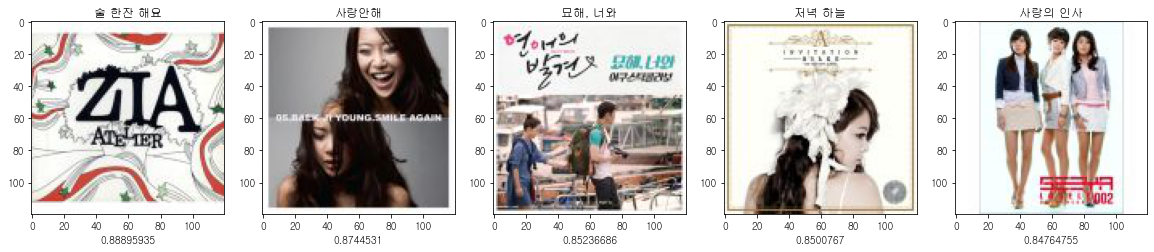

In [34]:
# 입력한 노래와 가장 비슷한 5곡 추천

a = input("노래 제목을 입력하세요 : ")
recommendations(a)

노래 제목을 입력하세요 : 사랑의 인사


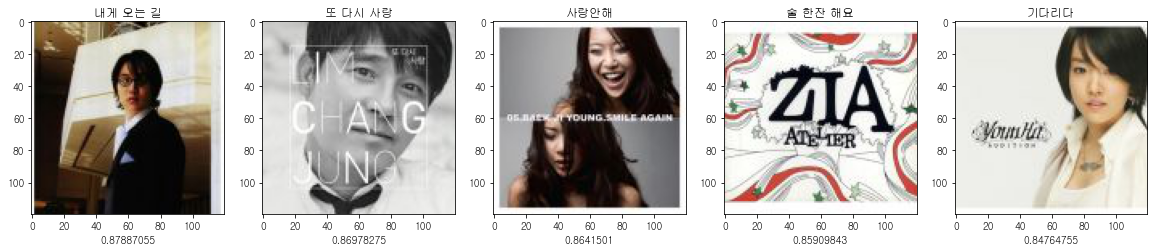

In [43]:
a = input("노래 제목을 입력하세요 : ")
recommendations(a)

In [45]:
# 비추천 시스템
def non_recommendations(title):
    books = df[['제목', '앨범 커버']]
    
    # 노래의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['제목']).drop_duplicates()
    idx = indices[title]

    # 입력된 노래와 가사가 유사하지 않은 노래 5곡 선정.
    sim_scores = list(enumerate(cosine_similarities[idx-1]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[45:50]


    # 가장 유사하지 않은 노래 5곡의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)
    
    fig = plt.figure(figsize=(20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['앨범 커버'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['제목'])
        plt.xlabel(sim_scores[index][1])

노래 제목을 입력하세요 : 기다리다


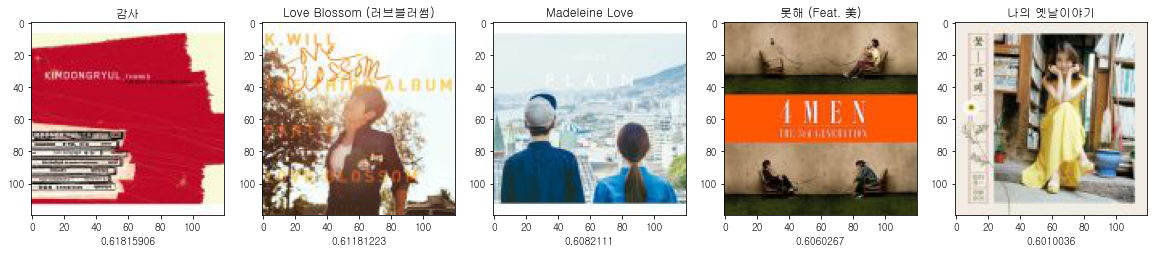

In [46]:
a = input("노래 제목을 입력하세요 : ")
non_recommendations(a)